# timeseries_local_outliers_detection

In [2]:
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
from meteostat import Point, Daily
from sklearn.neighbors import LocalOutlierFactor

# data

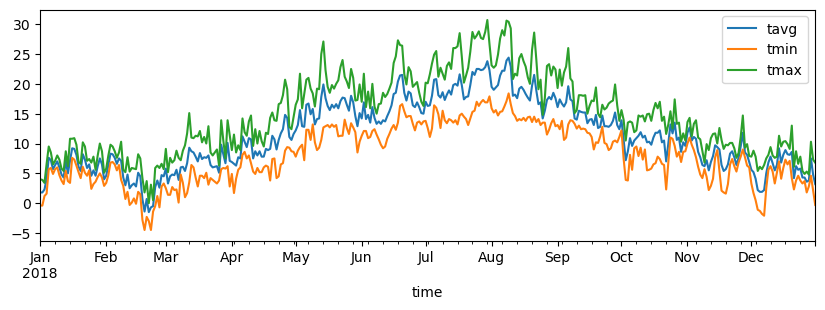

In [3]:

# Set time period
start = datetime(2018, 1, 1)
end = datetime(2018, 12, 31)

# Create Point for Vancouver, BC
location = Point(49.2497, -123.1193, 70)

# Get daily data for 2018
data = Daily(location, start, end)
data = data.fetch()

# Plot line chart including average, minimum and maximum temperature
_, ax = plt.subplots(figsize = (10,3))
data.plot(y=['tavg', 'tmin', 'tmax'], ax = ax)
plt.show()

# outlier detection

## fit_predict option (prediction without previous training)

### long ts

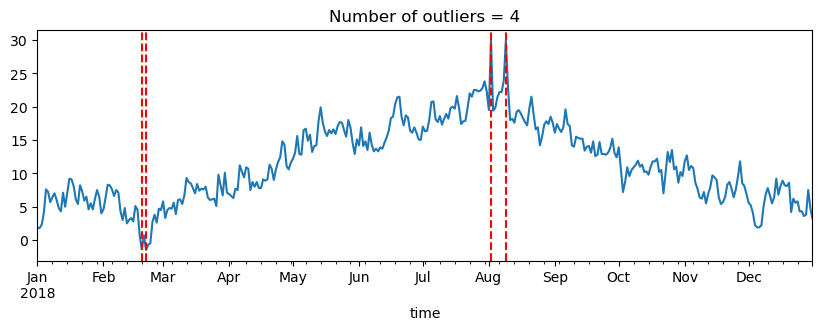

In [4]:
# create data
df = data[['tavg']].copy()
df.loc[df.index.isin(df.sample(2).index.tolist()), "tavg"] = 30.
# fit-predict
clf = LocalOutlierFactor(n_neighbors=20, contamination=0.01, novelty=False)
df["is_out"] = clf.fit_predict(df)
# plot
_, ax = plt.subplots(figsize = (10,3))
df["tavg"].plot(ax=ax, title = f'Number of outliers = {len(df[df["is_out"]==-1])}')
for idt in df[df["is_out"]==-1].index.tolist():
    ax.axvline(idt, color = 'red', linestyle = '--')
plt.show()


### sort ts

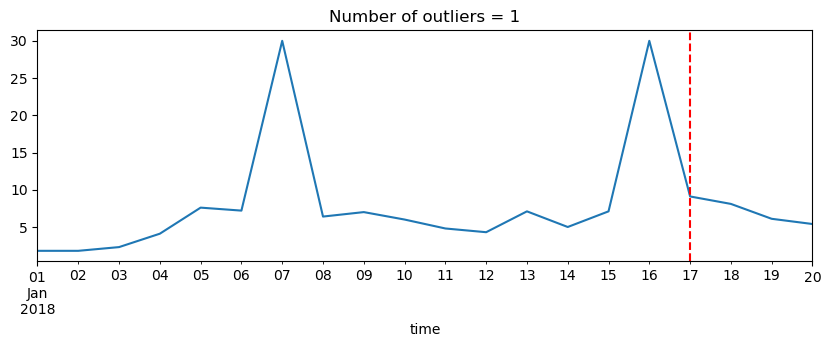

In [5]:
# create data
df = data[['tavg']].head(20)
df.loc[df.index.isin(df.sample(2).index.tolist()), "tavg"] = 30.
# fit-predict
clf = LocalOutlierFactor(n_neighbors=20, contamination=0.01, novelty=False)
df["is_out"] = clf.fit_predict(df)
# plot
_, ax = plt.subplots(figsize = (10,3))
df["tavg"].plot(ax=ax, title = f'Number of outliers = {len(df[df["is_out"]==-1])}')
for idt in df[df["is_out"]==-1].index.tolist():
    ax.axvline(idt, color = 'red', linestyle = '--')
plt.show()

#### conclusion

- No funciona muy bien con *novelty = False* para sort timeseries.

## fit (previous training) + predict option 

### long ts for training

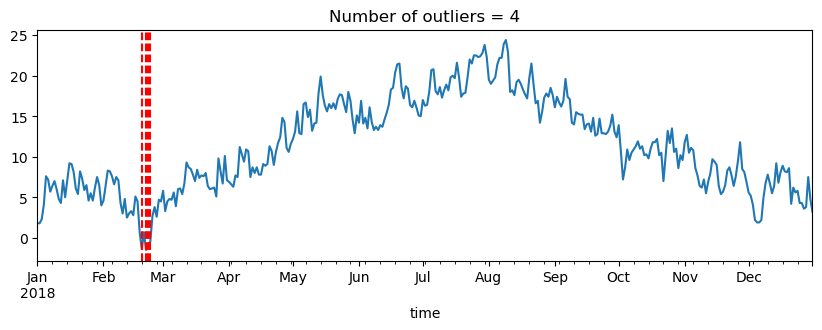

In [6]:
# create data
df = data[['tavg']].copy()
# fit-predict
clf = LocalOutlierFactor(n_neighbors=20, contamination=0.01, novelty=True)
clf.fit(df)
df["is_out"] = clf.predict(df)
# plot
_, ax = plt.subplots(figsize = (10,3))
df["tavg"].plot(ax=ax, title = f'Number of outliers = {len(df[df["is_out"]==-1])}')
for idt in df[df["is_out"]==-1].index.tolist():
    ax.axvline(idt, color = 'red', linestyle = '--')
plt.show()

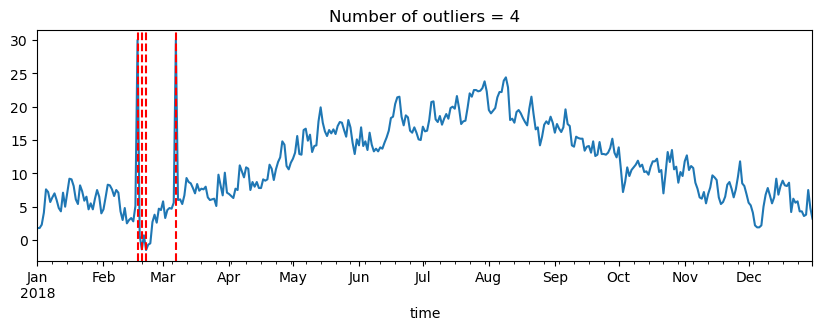

In [7]:
# create data
df = data[['tavg']].copy()
df.loc[df.index.isin(df.sample(2).index.tolist()), "tavg"] = 30.
df.dropna(inplace = True)
# fit-predict
clf = LocalOutlierFactor(n_neighbors=200, contamination=0.01, novelty=True)
clf.fit(df)
df["is_out"] = clf.predict(df)
# plot
_, ax = plt.subplots(figsize = (10,3))
df["tavg"].plot(ax=ax, title = f'Number of outliers = {len(df[df["is_out"]==-1])}')
for idt in df[df["is_out"]==-1].index.tolist():
    ax.axvline(idt, color = 'red', linestyle = '--')
plt.show()


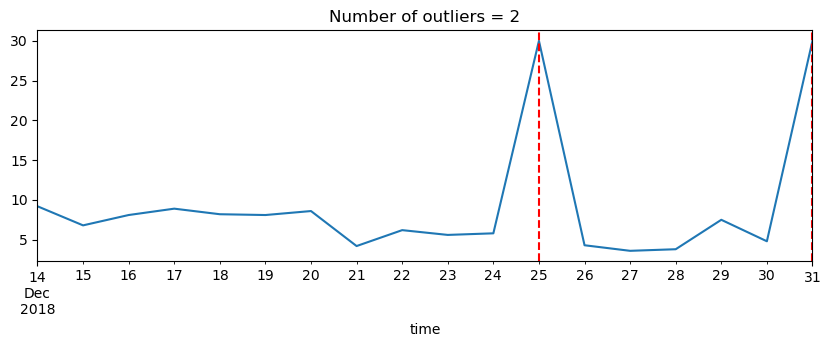

In [8]:
# create data
df = data[['tavg']].tail(18)
df.loc[df.index.isin(df.sample(2).index.tolist()), "tavg"] = 30.
# predict
df["is_out"] = clf.predict(df)
# plot
_, ax = plt.subplots(figsize = (10,3))
df["tavg"].plot(ax=ax, title = f'Number of outliers = {len(df[df["is_out"]==-1])}')
for idt in df[df["is_out"]==-1].index.tolist():
    ax.axvline(idt, color = 'red', linestyle = '--')
plt.show()

#### conclusion 

- funciona bastante bien.

## z-score of the moving median differences

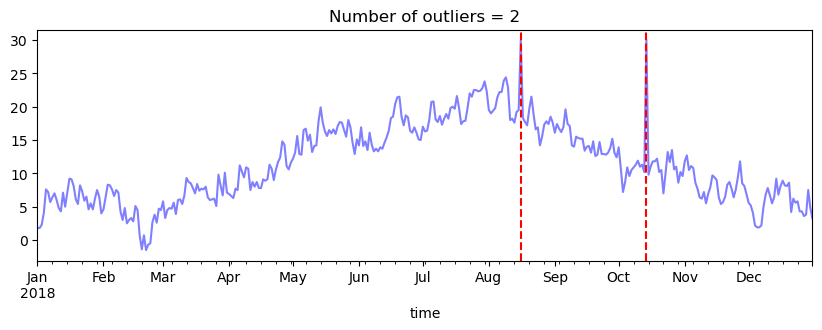

In [120]:
# create data
df = data[['tavg']].tail(24*6*100)
df.loc[df.index.isin(df.sample(2).index.tolist()), "tavg"] = 30.
# predict
df["med"] = df["tavg"].rolling(window=5, center=True, min_periods=5).apply(np.median)
df["diff"] = np.abs(df["tavg"] - df["med"])
df["diff"] = df["diff"].bfill(limit=2).ffill(limit=2)
mean_train = df["diff"].mean()
std_train = df["diff"].std()
df["zdiff"] = (df["diff"] - mean_train) / std_train
df["is_out"] = (df["zdiff"] > 4)
# plot
_, ax = plt.subplots(figsize = (10,3))
df["tavg"].plot(ax=ax, color = 'blue', alpha = .5)
#df["diff"].plot(ax=ax, color = 'red', alpha = .5)
ax.set_title(f'Number of outliers = {len(df[df["is_out"]==True])}')
for idt in df[df["is_out"]==True].index.tolist():
    ax.axvline(idt, color = 'red', linestyle = '--')
plt.show()

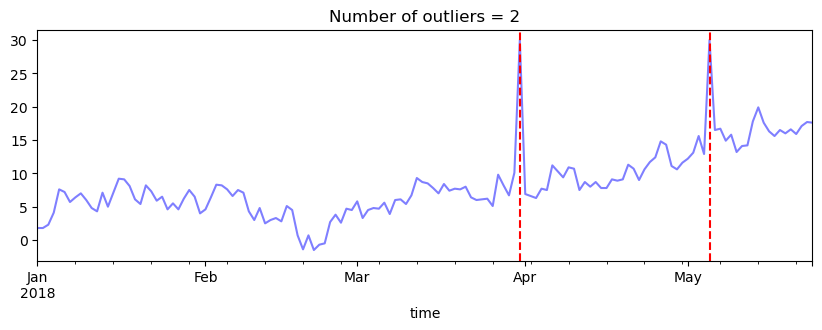

In [155]:
# create data
df = data[['tavg']].head(24*6)
df.loc[df.index.isin(df.sample(2).index.tolist()), "tavg"] = 30.
# predict
df["med"] = df["tavg"].rolling(window=5, center=True, min_periods=5).apply(np.median)
df["diff"] = np.abs(df["tavg"] - df["med"])
df["diff"] = df["diff"].bfill(limit=2).ffill(limit=2)
df["zdiff"] = (df["diff"] - mean_train) / std_train
df["is_out"] = (df["zdiff"] > 4)
# plot
_, ax = plt.subplots(figsize = (10,3))
df["tavg"].plot(ax=ax, color = 'blue', alpha = .5)
#df["diff"].plot(ax=ax, color = 'red', alpha = .5)
ax.set_title(f'Number of outliers = {len(df[df["is_out"]==True])}')
for idt in df[df["is_out"]==True].index.tolist():
    ax.axvline(idt, color = 'red', linestyle = '--')
plt.show()

#### Conclusion

- Funciona bien pero requiere un minimo de longitud para ser robusto.
- Supongo que un entrenamiento largo funciona mejor para luego predicciones mas cortas.